In [ ]:
# import packages
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.lines import Line2D

# function to add desal plan, deploy, and ramp down lines to time series plot
def add_desal_labels(ax, y_min, y_max, df_time_tracker):
    for i in range(len(df_time_tracker)):
        ax.plot([df_time_tracker['plan_date'].iloc[i], df_time_tracker['plan_date'].iloc[i]], [y_min, y_max], color='darkgray', linestyle=':', label='desal plan date')
        ax.plot([df_time_tracker['deploy_date'].iloc[i], df_time_tracker['deploy_date'].iloc[i]], [y_min, y_max], color='gray', linestyle=':', label='deploy date')
        ax.plot([df_time_tracker['ramp_down_date'].iloc[i], df_time_tracker['ramp_down_date'].iloc[i]], [y_min, y_max], color='black', linestyle=':', label='ramp down date')
        ax.axvspan(df_time_tracker['deploy_date'].iloc[i], df_time_tracker['ramp_down_date'].iloc[i], alpha=0.3, color='lightgray')
    ax.set_ylim(y_min, y_max)

# function to calculate df of ARs from dfs of bills and mapped income
def get_ARs(df_bill, df_inc):
    # calculate affordability ratios
    bill_cols = [col for col in df_bill.columns if col.startswith('bill_')]
    
    AR_data = {}
    for col in bill_cols:
        # perform AR calcs
        AR_col_name = col.replace('bill', 'AR', 1)
        AR_data[AR_col_name] = (df_bill[col] / (df_inc['map_inc_1']/12)) * 100
        
    # create new dataframe
    #print(AR_data)
    df_AR = pd.DataFrame(AR_data)
    return df_AR

# import dataframe and get dataframe in long format with columns: account, demand (value), month, year
def get_long_df(df, var_name):
    df = df.reset_index()
    df_long = pd.melt(df, id_vars=['index'], var_name='Month_Year', value_name=var_name)
    # Rename the 'index' column to 'Account'
    df_long.rename(columns={'index': 'Account'}, inplace=True)
    
    # Extract Month and Year from the 'Month_Year' column
    df_long['Month'] = df_long['Month_Year'].str.extract(r'_(\d{1,2})_')[0]  # Extract the month
    df_long['Month'] = df_long['Month'].astype(int)
    df_long['Year'] = df_long['Month_Year'].str.extract(r'_(\d{4})$')[0]    # Extract the year
    df_long['Year'] = df_long['Year'].astype(int)
    
    return df_long

# function to get dataframes of bills, demand, and ARs
def get_data(real, dP, dT, dCV, demand, income_class, filepath, om):
    # import data
    filename = filepath + 'df_sample_' + income_class + '_P{}T{}_dCV{}_real{}_demand{}{}.csv'.format(dP,dT,dCV,real, demand, om)
    df = pd.read_csv(filename, index_col=0)
    
    prefixes = set(col.split('_')[0] for col in df.columns)

    # Create a dictionary to store separated DataFrames
    split_dfs = {}
    
    # Iterate over each prefix and date combination
    for prefix in prefixes:
        matching_cols = [col for col in df.columns if col.startswith(prefix)]
            
        # create a dataframe if matching columns
        if matching_cols:
            #split_dfs[f"{prefix}_{date}"] = df[matching_cols]
            split_dfs[f"{prefix}"] = df[matching_cols]
    
    #print(split_dfs)
    df_inc = split_dfs["map"]
    df_demand = split_dfs["demand"]
    df_bill = split_dfs["bill"]
    # calculate ARs
    df_AR = get_ARs(df_bill, df_inc)
    return df_demand, df_bill, df_AR
    
# load a single combination into a long dataframe
def load_combinations_single(combo, income_class, om, filepath):
    # process data
    df_demand, df_bill, df_AR = get_data(combo[0], combo[2], combo[1], combo[3], combo[4], income_class, filepath, om)
    df_long = get_long_df(df_demand, 'Demand')
    df_long_bill = get_long_df(df_bill, 'Bill')
    df_long_AR = get_long_df(df_AR, 'AR')
    df_long['Bill'] = df_long_bill['Bill']
    df_long['AR'] = df_long_AR['AR']
    df_long['real'] = combo[0]
    df_long['dT'] = combo[1]
    df_long['dP'] = combo[2]
    df_long['dCV'] = combo[3]
    df_long['demand_scenario'] = combo[4]
    df_long['income_class'] = income_class
    df_long['date'] = pd.to_datetime(df_long[['Year', 'Month']].assign(day=1))
    
    return df_long

# create a function to get annual precip data by water year
def get_annual_water_yr_df(df_results):
    # get water year
    df_results['water_year'] = df_results.index.year + (df_results.index.month >= 10)
    s_precip_water_yr = df_results.groupby('water_year')['precip_LL_in'].sum() # get series
    df_precip_water_yr = s_precip_water_yr.to_frame() # convert to df
    df_precip_water_yr['date'] = pd.to_datetime(df_precip_water_yr.index, format='%Y') # add date column
    df_precip_water_yr = df_precip_water_yr.set_index('date') # change date col to index
    return df_precip_water_yr

# function to get multiple metrics aggregated annually
def get_multiple_aggregations_water_yr(df_results):
    df_water_year = (
    df_results
    .groupby('water_year')
    .agg({
        'precip_LL_in': 'sum',    # annual sum
        'LL_Reservoir_MG': 'mean'       # annual average of reservoir storage
    })
    .reset_index()
    )
    df_water_year['date'] = pd.to_datetime(df_water_year['water_year'].astype(str) + '-09-30')
    df_water_year = df_water_year.set_index('date')# change date col to index
    return df_water_year
    
# function to process the  daily water supply results from Pywr
def process_results(filepath, dP, dT, dCV, real, demand, name_add):
    df_results = pd.read_csv(filepath + 'df_results_{}P{}T{}_dCV{}_real{}_demand{}.csv'.format(name_add,dP,dT,dCV,real,demand))
    df_results['Date'] = pd.to_datetime(df_results['Date'])
    df_results['Month'] = df_results['Date'].dt.month
    df_results['Year'] = df_results['Date'].dt.year
    df_results = df_results.set_index('Date')
    df_results['precip_LL_MovAvg'] = df_results['precip_LL_in'].rolling(window=365*5, min_periods=1).sum() / 5
    return df_results

# function to process the risk-of-failure file
def process_rof(filepath, dP, dT, dCV, real, demand, name_add):
    df_rof = pd.read_csv(filepath + 'df_rof_{}P{}T{}_dCV{}_real{}_demand{}.csv'.format(name_add,dP,dT,dCV,real,demand))
    df_rof['Date'] = pd.to_datetime(df_rof['year'].astype(str) + '-10-01')
    df_rof = df_rof.set_index('Date')
    return df_rof

# function to import data from a random high and low income household
def import_random_household_data(filepath, real, dT, dP, dCV, demand, random_seed):
    # set random seed
    np.random.seed(random_seed)
    
    # import household-level data
    arr_hh = np.load(filepath + 'arr_hh_data_P{}T{}_dCV{}_real{}_demand{}.npy'.format(dP, dT, dCV, real, demand))
    
    # import household income data
    filepath_hh = '../../data/dcc_data/resampled_income_data_30Nov2024.csv'
    df_hh = pd.read_csv(filepath_hh)
    
    # 1. get list of low and high income households
    low_income_hhs = df_hh.loc[df_hh['map_inc_1'] < 40000, 'account']
    # get high income households
    high_income_hhs = df_hh.loc[df_hh['map_inc_1'] >= 174999.5, 'account']
    
    # 2. get random sample from households
    random_account_low = np.random.choice(low_income_hhs)
    random_account_high = np.random.choice(high_income_hhs)
    #print('random account low: {}, high: {}'.format(random_account_low, random_account_high))
    
    # 3. get household data (and convert to df)
    # get dates
    start_date = "2020-10-01"
    num_months = np.shape(arr_hh)[1]
    dates = pd.date_range(start=start_date, periods=num_months, freq='MS')
    # get dataframe for low income
    arr_hh_low = arr_hh[random_account_low,:,2]
    df_low = pd.DataFrame({'Date': dates, "AR": arr_hh_low})
    
    # get dataframe for high income
    arr_hh_high = arr_hh[random_account_high,:,2]
    df_high = pd.DataFrame({'Date': dates, "AR": arr_hh_high})
    
    # 4. add year and water_year columns
    df_low['Year'] = df_low['Date'].dt.year
    df_low['Water_Year'] = df_low['Year'] + (df_low['Date'].dt.month >= 10)
    df_high['Year'] = df_high['Date'].dt.year
    df_high['Water_Year'] = df_high['Year'] + (df_high['Date'].dt.month >= 10)

    return df_low, df_high, random_account_low, random_account_high

# function to process time tracker df
def process_time_tracker(filepath, dP, dT, dCV, real, demand):
    df_time_tracker = pd.read_csv(filepath + 'df_time_tracker_P{}T{}_dCV{}_real{}_demand{}.csv'.format(dP,dT,dCV,real,demand))
    col_names = ['plan_date', 'deploy_date', 'payback_date', 'ramp_down_date']
    if df_time_tracker.empty:
        return 0
    else:
        for col_name in col_names:
            df_time_tracker[col_name] = pd.to_datetime(df_time_tracker[col_name])
        return df_time_tracker

# function to aggregate annual AR data from monthly data
def get_annual_AR_data(df):
    df_ann = df.groupby('Year')['AR'].mean().reset_index()
    df_ann['Date'] = pd.to_datetime(df_ann['Year'].astype(str) + '-10-01')
    return df_ann
print('packages imported')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
packages imported


In [ ]:
# import image
image_path = "./utilities-data/XLRM_framework.png" # 3Feb
image = mpimg.imread(image_path) # load image

# wet scenario
#filepath_sims = # set filepath for where results files are saved
dP = 100
dT = 1
dCV = '1.0' 
real = 2770
demand = 'Baseline'
name_add = ''
df_results_wet = process_results(filepath_sims, dP, dT, dCV, real, demand, name_add)
df_time_tracker_wet = process_time_tracker(filepath_sims, dP, dT, dCV, real, demand)
df_results = df_results_wet.copy()
df_ann_precip_wet = get_annual_water_yr_df(df_results_wet)
df_ann_wet = get_multiple_aggregations_water_yr(df_results_wet)
seed = 36
df_low_wet, df_high_wet, acct_low_wet, acct_high_wet = import_random_household_data(filepath_sims, real, dT, dP, dCV, demand, seed)

# dry scenario
dP = 90
dT = 4
dCV = '1.2' #'1.2'
real = 1270
demand = 'Baseline' #'Low'
df_results_dry = process_results(filepath_sims, dP, dT, dCV, real, demand, name_add)
df_time_tracker_dry = process_time_tracker(filepath_sims, dP, dT, dCV, real, demand)
df_ann_precip_dry = get_annual_water_yr_df(df_results_dry)
df_ann_dry = get_multiple_aggregations_water_yr(df_results_dry)
df_low_dry, df_high_dry, acct_low_dry, acct_high_dry = import_random_household_data(filepath_sims, real, dT, dP, dCV, demand, seed)
df_rof_dry = process_rof(filepath_sims, dP, dT, dCV, real, demand, name_add)

# get results for dry scenario w/o inf
name_add = 'NoInf_'
df_results_dry_NoInf = process_results(filepath_sims, dP, dT, dCV, real, demand, name_add)
df_ann_precip_dry_NoInf = get_annual_water_yr_df(df_results_dry_NoInf) # adds water year data to df_results
df_ann_dry_NoInf = get_multiple_aggregations_water_yr(df_results_dry_NoInf)

# sample households
print('low income accounts: wet: {}, dry: {}'.format(acct_low_wet, acct_low_dry))
print('high income accounts: wet: {}, dry: {}'.format(acct_high_wet, acct_high_dry))
print(df_low_dry)
print(df_time_tracker_wet)
print(df_time_tracker_dry)

# aggregate monthly sample hh data to annual
df_ann_low_dry = get_annual_AR_data(df_low_dry)
df_ann_low_wet = get_annual_AR_data(df_low_wet)
df_ann_high_dry = get_annual_AR_data(df_high_dry)
df_ann_high_wet = get_annual_AR_data(df_high_wet)

low income accounts: wet: 20285, dry: 20285
high income accounts: wet: 1751, dry: 1751
          Date        AR  Year  Water_Year
0   2020-10-01  4.493031  2020        2021
1   2020-11-01  3.821100  2020        2021
2   2020-12-01  3.520612  2020        2021
3   2021-01-01  3.542164  2021        2021
4   2021-02-01  3.645577  2021        2021
..         ...       ...   ...         ...
595 2070-05-01  5.097865  2070        2070
596 2070-06-01  5.718518  2070        2070
597 2070-07-01  6.338164  2070        2070
598 2070-08-01  6.514620  2070        2070
599 2070-09-01  6.148442  2070        2070

[600 rows x 4 columns]
0
   Unnamed: 0   inf_option  desal_mgd  plan_date deploy_date payback_date  \
0           0  DESALT_4MGD          0 2023-10-01  2033-10-01   2053-10-01   
1           1          DPR          0 2058-10-01  2063-10-01   2088-10-01   

  ramp_down_date  capex_cost  opex_cost_annual  
0     2063-10-01   212445600           9953160  
1     2093-10-01   144697200           37

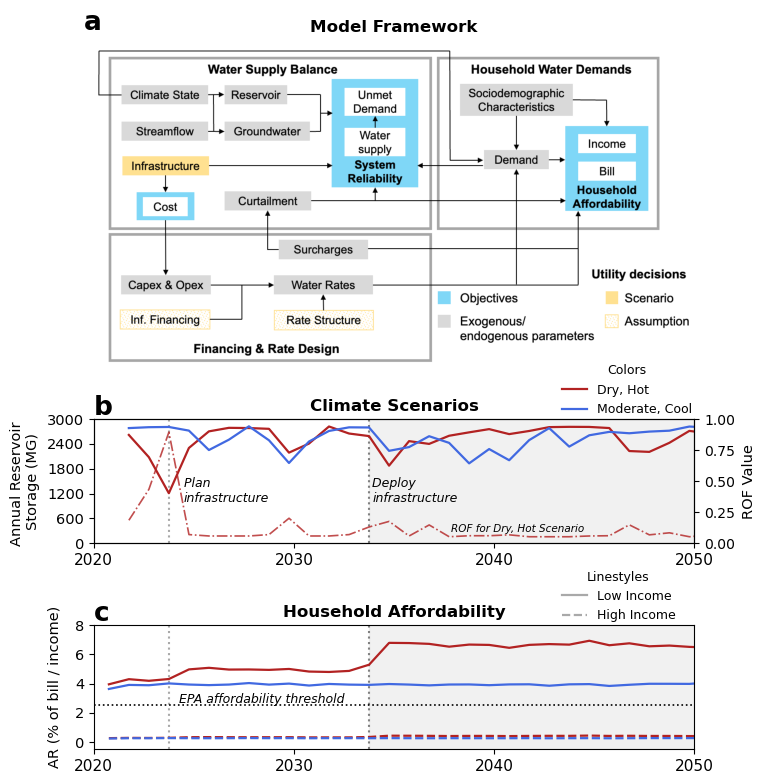

In [ ]:
# new version of plot: a- schematic, b- one wet and one dry STORAGE path, c- one high and one low income bill for each path (4 lines), d- ARs for the 4 lines above
# all bars stacked on top of each other
annual_avg = (92.3*12)/10/2.54 # inches
start_date = datetime(2020, 1, 1)
end_date = datetime(2070, 9, 30)
# create a figure
fig = plt.figure(figsize = (7.75, 9.5))
# define the grid layout
gs = gridspec.GridSpec(3, 1, height_ratios = [2.8, 1, 1], hspace=0.34) # 2.4

# First column (spanning all rows): display XLRM framework
ax0 = fig.add_subplot(gs[0, 0])  # Span all rows in the first column
ax0.imshow(image)
ax0.axis("off")
ax0.set_title('Model Framework', fontweight='bold', fontsize=12, pad=8)
ax0.text(-22, -30, 'a', fontsize=19, fontweight='bold')

# second subplot: two precipitation paths
ax10 = fig.add_subplot(gs[1, 0])
add_desal_labels(ax10, 0, 3000, df_time_tracker_dry)
ax10.plot(df_ann_dry['LL_Reservoir_MG'], linewidth=1.6, color='firebrick', label='Dry, Hot') # firebrick
#ax10.plot(df_ann_dry_NoInf['LL_Reservoir_MG'], linewidth=1.6, color='firebrick', linestyle=':', label='Dry, Hot') # firebrick
ax10.plot(df_ann_wet['LL_Reservoir_MG'], linewidth=1.6, color='royalblue', label='Moderate, Cool')
#ax10.plot([start_date, end_date], [annual_avg, annual_avg], linewidth=1.2, color='k', linestyle=':')
ax10.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2050-01-02'))
ax10.xaxis.set_major_locator(mdates.YearLocator(10))  # Set ticks every 10 years
ax10.tick_params(axis='x', labelsize=11)  # Adjust fontsize
ax10.text(datetime(2020, 1, 1), 3100, 'b', fontsize=19, fontweight='bold') # add b label
ax10.set_ylabel('Annual Reservoir \nStorage (MG)', labelpad=5, fontsize=10.5)
ax10.set_ylim(0, 3000)
ax10.set_yticks(np.arange(0, 3001, 600))
ax10.set_yticklabels(np.arange(0, 3001, 600), fontsize=10.5)
ax10.text(datetime(2024, 7, 1), 1000, 'Plan \ninfrastructure', fontsize=9, fontstyle='italic')
ax10.text(datetime(2033, 12, 1), 1000, 'Deploy \ninfrastructure', fontsize=9, fontstyle='italic')
#ax10.text(datetime(2035, 6, 1), 47, 'Historical avg.', fontsize=9, fontstyle='italic')
ax10.set_title('Climate Scenarios', fontweight='bold', fontsize=12)

# add custom legend
legend_elements = [
    Line2D([0], [0], color='firebrick', lw=1.6, label='Dry, Hot'),
    Line2D([0], [0], color='royalblue', lw=1.6, label='Moderate, Cool')
    #Line2D([0], [0], color='silver', lw=1.6, linestyle='-', label='Low Income Household'),
    #Line2D([0], [0], color='silver', lw=1.6, linestyle='-.', label='High Income Household')
]
legend = ax10.legend(handles=legend_elements, title='Colors', loc="upper left", bbox_to_anchor = (0.76, 1.53), fontsize=9, title_fontsize=9,  frameon=False) # title_fontweight='bold',

# add secondary axis for subplot
ax11 = ax10.twinx()
ax11.plot(df_rof_dry['rof'], color='firebrick', linestyle='-.', linewidth=1.2, label='ROF', alpha=0.8)
ax11.set_ylim((0.0, 1))
ax11.set_ylabel('ROF Value', labelpad=5, fontsize=10.5)
ax11.text(datetime(2037, 11, 1), 0.09, 'ROF for Dry, Hot Scenario', fontsize=7.5, fontstyle='italic')

# move subplot
left, bottom, width, height = ax10.get_position().bounds
ax10.set_position([left, bottom+0.03, width, height])

# third subplot: ARs
ax20 = fig.add_subplot(gs[2, 0])
add_desal_labels(ax20, -0.5, 8, df_time_tracker_dry)
# low income
col = 'AR'
#ax20.plot(df_low_dry['date'], df_low_dry[col], color='firebrick', linewidth=1.2, label='Low') # dry
#ax20.plot(df_low_wet['date'], df_low_wet[col], color='royalblue', linewidth=1.2, linestyle='-') # wet

# use these
ax20.plot(df_ann_low_dry['Date'], df_ann_low_dry[col], linewidth=1.6, color='firebrick', label='Dry')
ax20.plot(df_ann_low_wet['Date'], df_ann_low_wet[col], linewidth=1.6, color='royalblue', label='Wet')
# high income
ax20.plot(df_ann_high_dry['Date'], df_ann_high_dry[col], linewidth=1.6, color='firebrick', label='Dry', linestyle='--')
ax20.plot(df_ann_high_wet['Date'], df_ann_high_wet[col], linewidth=1.6, color='royalblue', label='Wet', linestyle='--')

# epa threshold
ax20.plot([start_date, end_date], [2.5, 2.5], color='k', linewidth=1.2, linestyle=':')
ax20.set_ylabel('AR (% of bill / income)', labelpad=10, fontsize=10.5)
#ax20.set_ylim(-0.2, 8)
ax20.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2050-1-02'))
ax20.xaxis.set_major_locator(mdates.YearLocator(10))  # Set ticks every 10 years
ax20.tick_params(axis='x', labelsize=11)  # Adjust fontsize
ax20.set_yticks([0, 2, 4, 6, 8])
ax20.set_yticklabels([0, 2, 4, 6, 8], fontsize=10.5)
ax20.text(datetime(2024, 4, 1), 2.7, 'EPA affordability threshold', fontsize=9, fontstyle='italic')
ax20.text(datetime(2020, 1, 1), 8.3, 'c', fontsize=19, fontweight='bold')
ax20.set_title('Household Affordability', fontweight='bold', fontsize=12)

# add custom legend
legend_elements = [
    Line2D([0], [0], color='darkgray', lw=1.6, linestyle='-', label='Low Income'),
    Line2D([0], [0], color='darkgray', lw=1.6, linestyle='--', label='High Income')
]
legend2 = ax20.legend(handles=legend_elements, title='Linestyles', loc="upper left", bbox_to_anchor = (0.76, 1.53), fontsize=9, title_fontsize=9, frameon=False) # title='Sample Households'
# move subplot
left, bottom, width, height = ax20.get_position().bounds
ax20.set_position([left, bottom+0.015, width, height])

# save figure
resolution_value = 1200
filepath = '../../outputs/Figures/Dec2025/'
plt.savefig(filepath + 'Fig1_ModelFramework.png', format="png", dpi=resolution_value, bbox_inches='tight')

plt.show()